# Python wrapper for PLINK
Contains additional functions to mimic output of HAPSBURG for downstream analysis
@Harald Ringbauer, October 2019

In [1]:
import pandas as pd
import numpy as np
import socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./PackagesSupport/h5_python/")
from h5_functions import hdf5_to_vcf, load_h5   # Import Function to convert hdf5 to vcf
sys.path.append("./PackagesSupport/parallel_runs/")
from helper_functions import split_up_roh_df, prepare_path  # To split up ground truth ROH

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### The PLINK core function

In [9]:
def run_plink(path_vcf, output_folder, window_snp=50, kb=500, het=1, threshold=0.05, gap=1000, density=50):
    """Run PLINK ROH Caller on path_vcf, and save results in output_folder"""
    !module load plink; plink --homozyg --vcf $path_vcf --homozyg-window-snp \
    $window_snp --homozyg-kb $kb --homozyg-window-het $het \
    --homozyg-window-threshold $threshold --homozyg-gap $gap \
    --homozyg-density $density --out $output_folder

# Functions to modify PLINK output for simulated Mosaic Data
Run PLINK on simulated Mosaic Data, for each individual, and save output into PLINK output folder
For post-processing: Need roh.csv as well as roh_gt.csv. The latter will be needed to copy over

In [10]:
### Step0: Convert HDF5 to VCF
def create_folders(input_base_folder):
    """Create Folders if not existing and returns """
    input_h5 = os.path.join(input_base_folder, "data.h5")
    input_vcf = os.path.join(input_base_folder, "data.vcf")
    
    if not os.path.exists(input_h5):
        raise RuntimeError(f"Create .vcf file: {input_h5}")
        
    plink_folder = os.path.join(input_base_folder,"plink_out/")
    if not os.path.exists(plink_folder):
        print(f"Creating Folder for: {plink_folder}")
        os.makedirs(plink_folder)
    
    return input_h5, input_vcf, plink_folder

def post_process_plink(plink_folder, new_dict):
    """Post Process the PLINK Result to match Hapsburg output. Load dataframe from plink_folder,
    modify and return data frame"""
    path_plink_roh = plink_folder + "roh.hom"
    df_plink = pd.read_csv(path_plink_roh, sep=r"\s+", engine="python")

    df_plink["StartM"] = df_plink["POS1"].map(new_dict)
    df_plink["EndM"] = df_plink["POS2"].map(new_dict)
    df_plink["lengthM"] = df_plink["EndM"] - df_plink["StartM"]
    df_plink.rename(columns = {"POS1":"Start", "POS2": "End", "IID":"iid", "CHR":"ch"}, inplace=True)
    df_plink["length"] = df_plink["End"] - df_plink["Start"]
    # Add all fields for roh.csv
    df_plink = df_plink[["Start", "End", "StartM", "EndM", "length", "lengthM", "iid", "ch"]]
    return df_plink

# Step 2.2: Split up results into roh.csv & roh_gt.csv
def split_up_inferred_roh(df_t, iid, save_path):
    """Extract only ROH from Individual iid and saves it to save_path"""
    df_iid = df_t[df_t["iid"]==iid]
    df_iid.to_csv(save_path, index=False)
    
def postprocess_iid(df_plink, input_base_folder, iids, ch=3, prefix_out=""):
    """Split up results into roh.csv and roh_gt.csv for each IID.
    df_plink: Data Frame with Plink results, formated correctly"""

    for iid in iids:
        output_base_folder = os.path.join(input_base_folder, "output/")
        path_out = prepare_path(output_base_folder, iid, ch, prefix_out=prefix_out, logfile=False)

        path_inferred = os.path.join(path_out, "roh.csv")
        split_up_inferred_roh(df_plink, iid, save_path=path_inferred)   # Split up Inferred ROH
        split_up_roh_df(input_base_folder, path_out, iid)  # Split up Ground Truth ROH
        
        
#############################################
### Combine all subfunctions

def full_plink_mosaic(input_base_folder, ch=3, prefix_out="plink/"):
    """Run PLINK on Mosaic Data Set in ./Simulated"""
    
    input_h5, input_vcf, plink_folder = create_folders(input_base_folder)
    hdf5_to_vcf(input_h5, input_vcf, chrom=ch) # Convert to VCF
    
    run_plink(input_vcf, plink_folder + "roh") # 1.1: Run PLINK on VCF
    
    ### Create the Mapping Dictionary
    print("Creating Map Dict...")
    f = load_h5(path=input_h5, output=False)
    map_dct = dict(zip(f["variants/POS"], f["variants/MAP"]))
    iids = f["samples"][:] # Get the IIDs
    
    print("Splitting up Plink results and GT...")
    df_plink =  post_process_plink(plink_folder, map_dct)
    postprocess_iid(df_plink, input_base_folder, iids, ch, prefix_out)
    print(f"Finished {len(iids)} Individuals!")

### Run all Individuals for Mosaic Folder

In [ ]:
%%time
full_plink_mosaic(input_base_folder = "./Simulated/1000G_Mosaic/TSI5/ch3_6cm",
                  ch=3, prefix_out="plink/")

### Run all lengths of copied in chromosomes

In [ ]:
base_path =  "./Simulated/1000G_Mosaic/TSI5/"

for l in [0, 2, 4, 6, 8, 10]:
    input_base_folder = base_path + f"ch3_{l}cm"
    print(f"\nDoing {input_base_folder}")
    full_plink_mosaic(input_base_folder = input_base_folder, ch=3, prefix_out="plink/")

# Call ROH on empirical Individual

In [ ]:
### Convert from VCF to HDF5

iids = []


In [15]:
### Call ROH




In [ ]:
### Postprocess ROH csv

# Area 51: Test code

In [19]:
### Figure out variants
def load_h5(path, output=True):
    """Load HDF5 from path and return hdf5 object"""
    f = h5py.File(path, "r") # Load for Sanity Check. See below!

    if output == True:
        print("Loaded HDF5")
        print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
        print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
        print(list(f["calldata"].keys()))
        print(list(f["variants"].keys()))
        #self.f["samples"] # Samples Vector

    ### Sanity Check whether both Genotypes are there and nothing else
    assert(np.min(f["calldata/GT"]) >= -1)
    assert(np.max(f["calldata/GT"]) <= 1)
    
    return f

f = load_h5(path="./Data/SA_1240kHDF5/Stuttgart.h5")

Loaded HDF5
Loaded 1115215 variants
Loaded 1 individuals
['AD', 'GT']
['ALT', 'CHROM', 'POS', 'REF']


In [26]:
f["calldata/AD"][:20,0,:]

array([[ 0, 24],
       [23,  0],
       [ 0, 13],
       [ 0, 17],
       [ 0, 18],
       [ 0, 24],
       [ 0, 29],
       [ 7,  0],
       [13,  7],
       [ 6,  9],
       [ 0, 16],
       [ 0, 22],
       [ 9,  5],
       [10, 10],
       [ 0, 16],
       [10,  1],
       [ 0, 10],
       [27,  0],
       [ 9, 13],
       [20,  0]], dtype=int32)

In [27]:
!bcftools

/bin/sh: bcftools: command not found


In [29]:
import matplotlib.pyplot as plt



<Figure size 640x480 with 1 Axes>

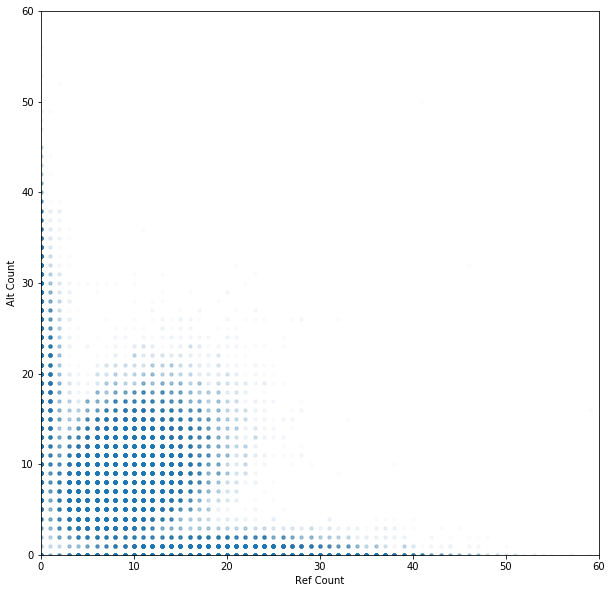

In [44]:
nsnps=200000

plt.figure(figsize=(10,10))
plt.scatter(f["calldata/AD"][:nsnps,0,0], f["calldata/AD"][:nsnps,0,1], s=10, alpha=0.02)
plt.xlabel("Ref Count")
plt.ylabel("Alt Count")
plt.xlim([0,60])
plt.ylim([0,60])
plt.show()